In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pickle
import optuna
print(f'Pickle Version: {pickle.format_version}')

Pickle Version: 4.0


In [2]:
_pth_tst = 'data/test_2022-08-08.csv'
_pth_trn = 'data/train_2021-12-24.csv'
_pth_emb = 'data/embeddings.pkl'
_pth_enc ='data/encoders.pkl'

train = pd.read_csv(_pth_trn)
test = pd.read_csv(_pth_tst)

with open(_pth_emb, 'rb') as handle:
    embeds = pickle.load(handle)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99144 entries, 0 to 99143
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sale_Price          99144 non-null  float64
 1   Odometer            99119 non-null  float64
 2   Power               99090 non-null  float64
 3   Fuel_Urban          87810 non-null  float64
 4   Make_Code           99144 non-null  object 
 5   Family_Code         99144 non-null  object 
 6   Year_Group          99144 non-null  int64  
 7   Region_Description  99144 non-null  object 
 8   Vehicle_Code        99144 non-null  int64  
 9   adv_date            99144 non-null  object 
 10  sld_date            99144 non-null  object 
 11  inventory_days      99144 non-null  int64  
 12  age_list_day        99144 non-null  int64  
 13  age_sell_day        99144 non-null  int64  
 14  sld_wknum           99144 non-null  int64  
 15  adv_wknum           99144 non-null  int64  
 16  km_p

In [4]:
train.columns

Index(['Sale_Price', 'Odometer', 'Power', 'Fuel_Urban', 'Make_Code',
       'Family_Code', 'Year_Group', 'Region_Description', 'Vehicle_Code',
       'adv_date', 'sld_date', 'inventory_days', 'age_list_day',
       'age_sell_day', 'sld_wknum', 'adv_wknum', 'km_per_day',
       'fuel_per_power', 'odo_per_fuel', 'odo_per_power', 'pow_times_odo'],
      dtype='object')

In [5]:
feat_cols = ['Odometer', 'Power', 'Fuel_Urban', 'inventory_days', 
             'age_sell_day', 'km_per_day', 'fuel_per_power', 
             'odo_per_fuel', 'odo_per_power','pow_times_odo']

enc_cols = list(embeds)
enc_cols

['Make_Code', 'Family_Code', 'Region_Description']

In [6]:
def get_embedded_feat(feat, encod_dict, feat_name='Family_Code'):
    '''Return embeddings from feature column using encoded dict
    '''
    feat_df = feat.to_frame()
    encodings = encod_dict[feat_name].reset_index()
    feat_tranf = feat_df.merge(encodings, how='left', left_on=[feat_name], right_on=['index'], indicator=True)
    print(feat_tranf._merge.value_counts())
    return feat_tranf.loc[:,[c for c in encodings.columns if c.startswith(feat_name)]]

In [7]:
embed_dflist = []
embed_dflist_test = []


for f in list(embeds):
    df = get_embedded_feat(train[f], embeds, feat_name=f)
    embed_dflist.append(df)
    df_test = get_embedded_feat(test[f], embeds, feat_name=f)
    embed_dflist_test.append(df_test)

both          99144
left_only         0
right_only        0
Name: _merge, dtype: int64
both          17496
left_only         1
right_only        0
Name: _merge, dtype: int64
both          99144
left_only         0
right_only        0
Name: _merge, dtype: int64
both          17461
left_only        36
right_only        0
Name: _merge, dtype: int64
both          99144
left_only         0
right_only        0
Name: _merge, dtype: int64
both          17497
left_only         0
right_only        0
Name: _merge, dtype: int64


In [8]:
X_train_df = pd.concat([train.loc[:,feat_cols]]+embed_dflist, axis=1)
y_train = train.loc[:,'Sale_Price']

X_test_df = pd.concat([test.loc[:,feat_cols]]+embed_dflist_test, axis=1)
y_test = test.loc[:,'Sale_Price']

In [9]:
knn = KNNImputer()
X_train = knn.fit_transform(X_train_df)
X_test = knn.transform(X_test_df)

<AxesSubplot:>

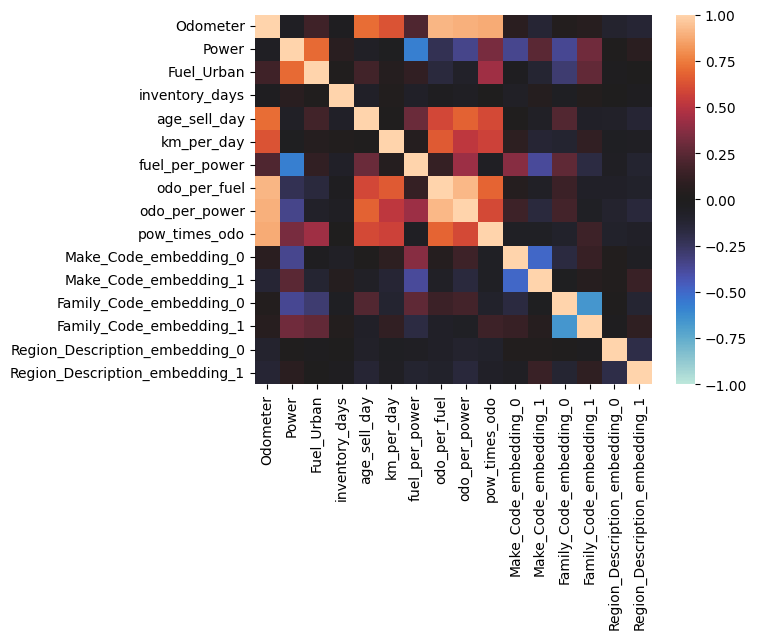

In [10]:
sns.heatmap(X_train_df.corr(), vmax=1, vmin=-1, center=0)

In [11]:
# Tuning with optuna
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-8, 1e8, log=True)
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    
    return cross_val_score(pipe, X_train, y_train, n_jobs=-1, cv=10, scoring='r2').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-08-24 17:40:39,259] A new study created in memory with name: no-name-ff9b075a-c214-4844-8a7e-71c61faa83f1
[I 2022-08-24 17:40:44,971] Trial 0 finished with value: 0.005986008917229613 and parameters: {'alpha': 12339726.216173308}. Best is trial 0 with value: 0.005986008917229613.
[I 2022-08-24 17:40:45,360] Trial 1 finished with value: 0.025097610581639306 and parameters: {'alpha': 7643362.124859679}. Best is trial 1 with value: 0.025097610581639306.
[I 2022-08-24 17:40:45,655] Trial 2 finished with value: 0.7769430288665278 and parameters: {'alpha': 1.4925112157689565e-08}. Best is trial 2 with value: 0.7769430288665278.
[I 2022-08-24 17:40:45,936] Trial 3 finished with value: -0.013975634798469593 and parameters: {'alpha': 31889679.692010984}. Best is trial 2 with value: 0.7769430288665278.
[I 2022-08-24 17:40:46,203] Trial 4 finished with value: 0.7769430288716024 and parameters: {'alpha': 4.3080925125928894e-06}. Best is trial 4 with value: 0.7769430288716024.
[I 2022-08-24

In [12]:
pipe = make_pipeline(StandardScaler(), Ridge(**study.best_params))
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=752.7567148834216))])


In [13]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=752.7567148834216))])

In [14]:
from sklearn.metrics import r2_score, explained_variance_score

In [15]:
y_pred = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

In [16]:
r2_score(y_train,y_pred_train,multioutput='variance_weighted'), explained_variance_score(y_train,y_pred_train)

(0.7852644806572313, 0.7852644806572314)

In [17]:
r2_score(y_test,y_pred,multioutput='variance_weighted'), explained_variance_score(y_test,y_pred)

(0.6792531848613996, 0.7502678526405535)

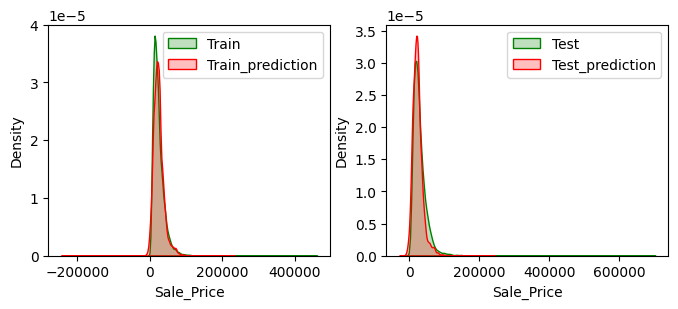

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))
sns.kdeplot(y_train,color='green',shade=True, ax=ax[0], label='Train') # train
sns.kdeplot(y_pred_train,color='red',shade=True, ax=ax[0])
ax[0].legend(labels=["Train","Train_prediction"])

sns.kdeplot(y_test,color='green',shade=True, ax=ax[1]) # test
sns.kdeplot(y_pred,color='red',shade=True, ax=ax[1])
ax[1].legend(labels=["Test","Test_prediction"])

plt.show()

In [19]:
ridge_model = pipe.named_steps['ridge']
ridge_model.get_params()

{'alpha': 752.7567148834216,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [20]:
sorted(list(zip(ridge_model.coef_, X_train_df.columns)), key=lambda x: x[0], reverse=True)

[(8040.877219489293, 'Power'),
 (4693.82067624151, 'Family_Code_embedding_1'),
 (3924.150036023039, 'odo_per_power'),
 (3717.9335975801914, 'Make_Code_embedding_1'),
 (428.1083860441332, 'fuel_per_power'),
 (113.13694816073506, 'Odometer'),
 (108.41217205918866, 'Region_Description_embedding_0'),
 (21.850137300627317, 'inventory_days'),
 (-17.72653573221313, 'Region_Description_embedding_1'),
 (-327.8538467291498, 'km_per_day'),
 (-1614.5670356005667, 'odo_per_fuel'),
 (-2421.2700059044255, 'Fuel_Urban'),
 (-3889.070982513802, 'age_sell_day'),
 (-4292.163761405995, 'Make_Code_embedding_0'),
 (-4542.329953897458, 'Family_Code_embedding_0'),
 (-4818.730292791567, 'pow_times_odo')]

## Try log-transform of target

In [37]:
y_train_log = np.log(train.loc[:,'Sale_Price'])
y_test_log = np.log(test.loc[:,'Sale_Price'])

In [68]:
# Tuning with optuna
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-8, 1e8, log=True)
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha,fit_intercept=False))
    
    return cross_val_score(pipe, X_train, y_train_log, n_jobs=-1, cv=10, scoring='r2').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2022-08-24 14:28:39,276] A new study created in memory with name: no-name-213be100-480e-4a17-a75c-072367b2e710
[I 2022-08-24 14:28:45,279] Trial 0 finished with value: -253.64528981373715 and parameters: {'alpha': 7.40357454796413e-05}. Best is trial 0 with value: -253.64528981373715.
[I 2022-08-24 14:28:45,761] Trial 1 finished with value: -253.6452932117167 and parameters: {'alpha': 4.20131599150294}. Best is trial 0 with value: -253.64528981373715.
[I 2022-08-24 14:28:46,070] Trial 2 finished with value: -253.6452898139873 and parameters: {'alpha': 0.00038311597560885613}. Best is trial 0 with value: -253.64528981373715.
[I 2022-08-24 14:28:46,333] Trial 3 finished with value: -253.64528984716944 and parameters: {'alpha': 0.041378711135273645}. Best is trial 0 with value: -253.64528981373715.
[I 2022-08-24 14:28:46,601] Trial 4 finished with value: -253.64530870455482 and parameters: {'alpha': 23.449772355097725}. Best is trial 0 with value: -253.64528981373715.
[I 2022-08-24 14:

In [79]:
study.best_params

{'alpha': 4.345570133864625e-08}

In [88]:
pipe = make_pipeline(StandardScaler(), Ridge(**study.best_params,fit_intercept=False))
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge',
                 Ridge(alpha=4.345570133864625e-08, fit_intercept=False))])


In [89]:
pipe.fit(X_train,y_train_log)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge',
                 Ridge(alpha=4.345570133864625e-08, fit_intercept=False))])

In [90]:
y_pred_log = pipe.predict(X_test)
y_pred_train_log = pipe.predict(X_train)

y_pred_nlog = np.exp(y_pred_log)
y_pred_train_nlog = np.exp(y_pred_train_log)

In [91]:
r2_score(y_train_log, y_pred_train_log, multioutput='variance_weighted'), \
explained_variance_score(y_train_log, y_pred_train_log)

(-245.58817425491083, 0.821237707537745)

In [92]:
r2_score(y_train_log, y_pred_train_log, multioutput='variance_weighted'), \
explained_variance_score(y_train_log, y_pred_train_log)

(-245.58817425491083, 0.821237707537745)

In [93]:
r2_score(y_train, y_pred_train_nlog, multioutput='variance_weighted'), \
explained_variance_score(y_train, y_pred_train_nlog)

(-1.914522808777967, 0.0001800976440141655)

In [94]:
r2_score(y_test,y_pred_nlog, multioutput='variance_weighted'), \
explained_variance_score(y_test,y_pred_nlog)

(-1.7491153012885134, 0.00020193524534917184)

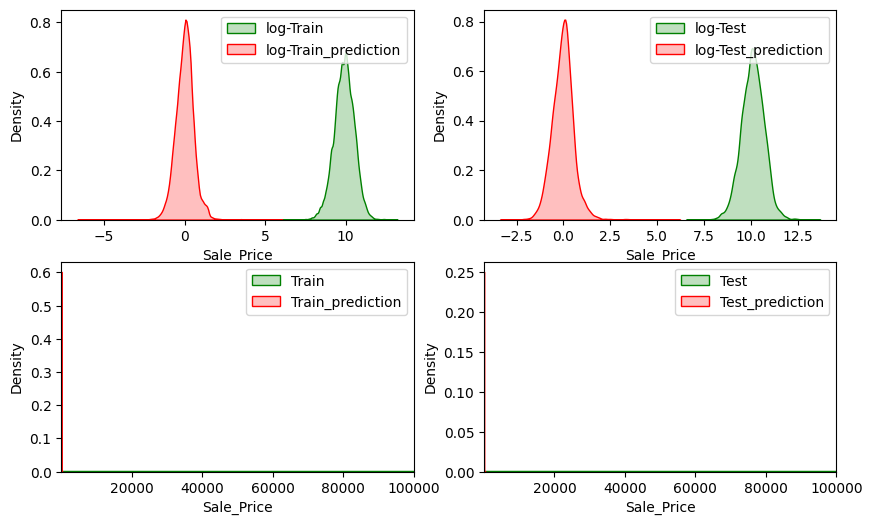

In [95]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(10,6))

ax = ax.ravel()
sns.kdeplot(y_train_log,color='green',shade=True, ax=ax[0], label='Train') # train
sns.kdeplot(y_pred_train_log,color='red',shade=True, ax=ax[0])
ax[0].legend(labels=["log-Train","log-Train_prediction"])

sns.kdeplot(y_test_log,color='green',shade=True, ax=ax[1]) # test
sns.kdeplot(y_pred_log,color='red',shade=True, ax=ax[1])
ax[1].legend(labels=["log-Test","log-Test_prediction"])

sns.kdeplot(y_train,color='green',shade=True, ax=ax[2], label='Train') # train
sns.kdeplot(y_pred_train_nlog,color='red',shade=True, ax=ax[2])
ax[2].legend(labels=["Train","Train_prediction"])
ax[2].set_xlim(1e0,1e5)

sns.kdeplot(y_test,color='green',shade=True, ax=ax[3]) # test
sns.kdeplot(y_pred_nlog,color='red',shade=True, ax=ax[3])
ax[3].legend(labels=["Test","Test_prediction"])
ax[3].set_xlim(1e0,1e5)

plt.show()

## XGBoost

In [21]:
import xgboost as xgb

In [22]:
def objective(trial, X_train=X_train, y_train=y_train):
    param = {
        "silent": 1,
        "objective": "reg:squarederror",
        "eval_metric": r2_score,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0e6),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0e6),
    }
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 2, 5)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 0.05)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    
    model = xgb.XGBRegressor(**param)
    
    return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=10, scoring='r2').mean()

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-08-24 17:41:13,920] A new study created in memory with name: no-name-7510868e-ec6f-4194-87c6-7bbd76b06857
[I 2022-08-24 17:42:02,443] Trial 0 finished with value: 0.5792277280137229 and parameters: {'booster': 'dart', 'lambda': 7.341291637093605e-07, 'alpha': 136.0143559391791, 'max_depth': 2, 'eta': 0.01716161490060774, 'gamma': 1.7752443472857077e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00722758982110907, 'skip_drop': 2.1591219956878195e-05}. Best is trial 0 with value: 0.5792277280137229.
[I 2022-08-24 17:42:04,632] Trial 1 finished with value: 0.7714924905088067 and parameters: {'booster': 'gblinear', 'lambda': 0.004327122307095463, 'alpha': 7.971854341726149e-06}. Best is trial 1 with value: 0.7714924905088067.
[I 2022-08-24 17:43:08,671] Trial 2 finished with value: 0.043502777143481094 and parameters: {'booster': 'dart', 'lambda': 0.00488525049918355, 'alpha': 7081.370564985375, 'max_depth': 4, 'eta': 0.00943655

[17:41:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:42:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:42:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x

[I 2022-08-24 18:02:16,292] Trial 7 finished with value: -1.9865997863363194 and parameters: {'booster': 'dart', 'lambda': 2.270322580104672e-05, 'alpha': 0.002527127257727885, 'max_depth': 5, 'eta': 4.556378988028347e-05, 'gamma': 7.880041848362374e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00013498268321392496, 'skip_drop': 0.05441955112760843}. Best is trial 1 with value: 0.7714924905088067.
[I 2022-08-24 18:02:20,664] Trial 8 finished with value: 0.7716489050682623 and parameters: {'booster': 'gblinear', 'lambda': 0.0042533854974603665, 'alpha': 9.065549260484552e-07}. Best is trial 8 with value: 0.7716489050682623.
[I 2022-08-24 18:02:55,446] Trial 9 finished with value: 0.38767099232942537 and parameters: {'booster': 'gbtree', 'lambda': 9.084668803398645e-06, 'alpha': 1.4407366622615435e-08, 'max_depth': 5, 'eta': 0.00909771434526584, 'gamma': 0.01044982777554765, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 0.7

[17:41:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:41:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:42:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x

[I 2022-08-24 18:30:30,546] Trial 32 finished with value: 0.7753493404042261 and parameters: {'booster': 'gblinear', 'lambda': 0.0017136346687168123, 'alpha': 0.42008604043095044}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 18:30:49,205] Trial 33 finished with value: 0.7367031001562231 and parameters: {'booster': 'gblinear', 'lambda': 0.013663289678005078, 'alpha': 39.6633024295625}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 18:31:09,088] Trial 34 finished with value: 0.5387221647456878 and parameters: {'booster': 'gblinear', 'lambda': 0.0006837822736493985, 'alpha': 729.3080186658719}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 18:31:22,510] Trial 35 finished with value: 0.7753188607893086 and parameters: {'booster': 'gblinear', 'lambda': 2.3294566808672066e-06, 'alpha': 6.427999825110204}. Best is trial 26 with value: 0.7756704308922255.


[18:06:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x

[I 2022-08-24 18:37:14,452] Trial 36 finished with value: -2.0115283216063506 and parameters: {'booster': 'dart', 'lambda': 0.02441966190806143, 'alpha': 7.799220982428414e-05, 'max_depth': 5, 'eta': 1.487452612866671e-06, 'gamma': 0.003246081125603541, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.143296144999576e-07, 'skip_drop': 0.5940803601355317}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 18:37:30,658] Trial 37 finished with value: 0.7755895227790599 and parameters: {'booster': 'gblinear', 'lambda': 0.0007497817735984481, 'alpha': 0.7796907386261793}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 18:38:12,688] Trial 38 finished with value: -1.8092258048444259 and parameters: {'booster': 'gbtree', 'lambda': 1.2500212951607457, 'alpha': 0.0016372752785339317, 'max_depth': 3, 'eta': 0.0003961761339809195, 'gamma': 3.220206141006795e-05, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0

[18:06:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x

[I 2022-08-24 18:59:14,359] Trial 46 finished with value: -2.01235563684891 and parameters: {'booster': 'gbtree', 'lambda': 2.1270950437744607e-06, 'alpha': 0.008691452742506885, 'max_depth': 2, 'eta': 3.5242894108868145e-08, 'gamma': 7.416073187748762e-06, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 19:05:03,549] Trial 47 finished with value: -2.0122090193648843 and parameters: {'booster': 'dart', 'lambda': 0.0027890136758764845, 'alpha': 0.07082881521839302, 'max_depth': 5, 'eta': 2.890240151086255e-07, 'gamma': 0.0004774341950844019, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.418750016533459e-06, 'skip_drop': 0.0006454849471659017}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 19:05:18,185] Trial 48 finished with value: 0.775203979362316 and parameters: {'booster': 'gblinear', 'lambda': 5.247992715963061e-06, 'alpha': 0.0014419433846830912}. Best is trial 26 with val

[18:06:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x

[I 2022-08-24 19:05:37,247] Trial 49 finished with value: 0.7752333694471882 and parameters: {'booster': 'gblinear', 'lambda': 2.0498657580631205e-07, 'alpha': 0.5621071422158976}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 19:05:52,962] Trial 50 finished with value: 0.4820138030303477 and parameters: {'booster': 'gblinear', 'lambda': 197.62306111774606, 'alpha': 0.042771878507434434}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 19:06:09,305] Trial 51 finished with value: 0.7755139612800961 and parameters: {'booster': 'gblinear', 'lambda': 0.0005379847617056192, 'alpha': 0.008414238963884917}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 19:06:26,737] Trial 52 finished with value: 0.7755890443271719 and parameters: {'booster': 'gblinear', 'lambda': 0.0008700645245425631, 'alpha': 0.0059895685776462145}. Best is trial 26 with value: 0.7756704308922255.
[I 2022-08-24 19:06:44,957] Trial 53 finished with value: 0.775316802087505 and

[18:42:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:42:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:42:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x

[I 2022-08-24 19:10:21,937] Trial 61 finished with value: 0.8630415449709797 and parameters: {'booster': 'gbtree', 'lambda': 2.8976985477938377e-08, 'alpha': 5358.607669479516, 'max_depth': 3, 'eta': 0.04892320430023906, 'gamma': 0.09769476891213934, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.8630415449709797.
[I 2022-08-24 19:11:09,655] Trial 62 finished with value: 0.8597992092213433 and parameters: {'booster': 'gbtree', 'lambda': 7.925879120351729e-08, 'alpha': 31435.30398642325, 'max_depth': 3, 'eta': 0.04351175020639651, 'gamma': 0.08654651118012827, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.8630415449709797.


[18:02:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:02:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:03:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x

[I 2022-08-24 19:12:00,702] Trial 63 finished with value: 0.8490854845635247 and parameters: {'booster': 'gbtree', 'lambda': 5.718756524472144e-08, 'alpha': 235531.36551283672, 'max_depth': 3, 'eta': 0.03782210872388376, 'gamma': 0.0727618218130048, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.8630415449709797.
[I 2022-08-24 19:12:57,459] Trial 64 finished with value: 0.8537190223913175 and parameters: {'booster': 'gbtree', 'lambda': 5.137778440145349e-08, 'alpha': 857996.34311706, 'max_depth': 3, 'eta': 0.04520419160987557, 'gamma': 0.08773999594625619, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.8630415449709797.
[I 2022-08-24 19:13:54,973] Trial 65 finished with value: 0.8552891388474141 and parameters: {'booster': 'gbtree', 'lambda': 9.882624334028291e-08, 'alpha': 627100.4281678646, 'max_depth': 3, 'eta': 0.044972837389890136, 'gamma': 0.10880900169109423, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.8630415449709797.
[I 2022-08-24 19:

ly here. Please open an issue if you find any such cases.


[18:08:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:09:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:30:01] WARNING: /Users/runner/

[I 2022-08-24 22:00:53,543] Trial 97 finished with value: 0.29096113291858144 and parameters: {'booster': 'gbtree', 'lambda': 3.612226596277769e-06, 'alpha': 136367.60343727525, 'max_depth': 3, 'eta': 0.009228307715955099, 'gamma': 3.7097843791419793e-08, 'grow_policy': 'lossguide'}. Best is trial 93 with value: 0.864531446762227.
[I 2022-08-24 22:20:10,767] Trial 98 finished with value: 0.8520598678361235 and parameters: {'booster': 'dart', 'lambda': 1.228136181641055e-05, 'alpha': 2797.423569284913, 'max_depth': 4, 'eta': 0.026732548759711004, 'gamma': 6.830937247829665e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0014451803724923364, 'skip_drop': 2.0772862684689083e-06}. Best is trial 93 with value: 0.864531446762227.
[I 2022-08-24 22:37:19,140] Trial 99 finished with value: -1.9403883405291489 and parameters: {'booster': 'gbtree', 'lambda': 1.3135433701466585e-06, 'alpha': 373249.0423464452, 'max_depth': 3, 'eta': 0.00013695

In [24]:
model = xgb.XGBRegressor(**study.best_params)

In [25]:
model.fit(X_train,y_train)

XGBRegressor(alpha=480.8333522422677, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=1, early_stopping_rounds=None,
             enable_categorical=False, eta=0.04985360412001637,
             eval_metric=None, gamma=6.931337905653002e-08, gpu_id=-1,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints='', lambda=1.3016152293166926e-07,
             learning_rate=0.0498536043, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [26]:
model.score(X_train,y_train)

0.8801738020203425

In [27]:
model.score(X_test,y_test)

0.7626250811526297